Запросами на языке SQL и методами библиотеки PySpark извлечены данные о внутренних пассажирскии перевозках одной из российских авиакомпаний. Перед нами стоит задача проверить гипотезу о различии среднего спроса на билеты во время различных культурных

Данные таблиц выгрузки:

**query_1.csv** — результат первого запроса. В нём содержится такая информация:

- *model* — **модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов *model* в сентябре 2018 года.

**query_3.csv** — результат третьего запроса. В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город (*city*) за день в сентябре 2018 года.

**query_last.csv** — результат последнего запроса. В нём следующая информация:

- *week_number* — **номер недели;
- *ticket_amount* — количество проданных билетов за неделю;
- *festival_week —* есть ли на этой неделе фестиваль;
- *festival_name —* название фестиваля.


# 1. Аналитика

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import datetime

По очереди загрузим таблицы с данными и просмотрим общую информацию

In [2]:
airplane_models=pd.read_csv('/datasets/query_1.csv')

In [3]:
airplane_models

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [4]:
airplane_models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


В таблице содержится 8 записей, для каждой модели самолетов показано количество полетов за сентябрь 2018 года. Типы данных соответствуют логическому содержанию, количество полетов описывается целыми числами.

___

In [5]:
city_flights=pd.read_csv('/datasets/query_3.csv')

In [6]:
city_flights

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


In [7]:
city_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [8]:
city_flights.describe()

,average_flights
count,101.000000
mean,5.494189
std,13.119790
min,1.000000
25%,2.000000
50%,3.000000
75%,5.870968
max,129.774194


В данной таблице содержится среднее количество прибывающих в город рейсов за сентябрь 2018 года. Всего есть записи о 101 городе. Типы данных в порядке, среднее количество рейсов описывается числом с плавающей точкой. 

Выберем 10 городов с самым большим количеством рейсов. 

In [9]:
city_flights.sort_values('average_flights', ascending=False).head(10)

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


___

Построим для наглядности необходимые графики и проанализируем их. 

In [10]:
plt.rcParams['figure.figsize'] = (20.0, 10.0) # изменим дефолтный размер графиков для более удобного восприятия

1. Количество рейсов по модели самолета.

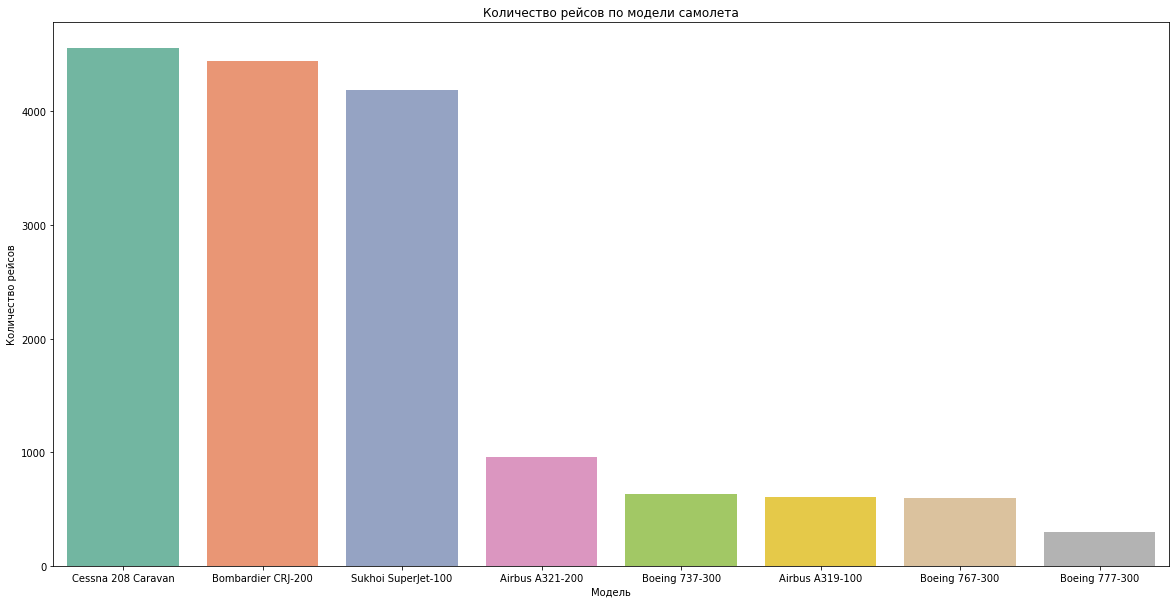

In [11]:
sns.barplot(x="model", y="flights_amount", data=airplane_models,
           order = airplane_models.sort_values('flights_amount', ascending=False)['model'], palette='Set2')
plt.title('Количество рейсов по модели самолета')
plt.xlabel('Модель')
plt.ylabel('Количество рейсов');

По каким-то причинам распределение моделей самолетов совершенно не соответствует таковому в реальности. 

<details>
  <summary>Данные по самолетам в России</summary>
  
  Исследование по российскому авиапарку за 2015 год. За это время вряд ли изменилось многое.
    https://www.rbc.ru/research/society/27/11/2015/564de81a9a79472dab71463a
  
</details>

Больше всего полетов если верить этим данным приходится на Cessna 208, который на деле в России эксплуатируют крайне ограниченно. Тут вопрос уже к источнику данных (вероятнее всего изначально данные из какой-то другой страны) 

2. Среднее количество рейсов по городам

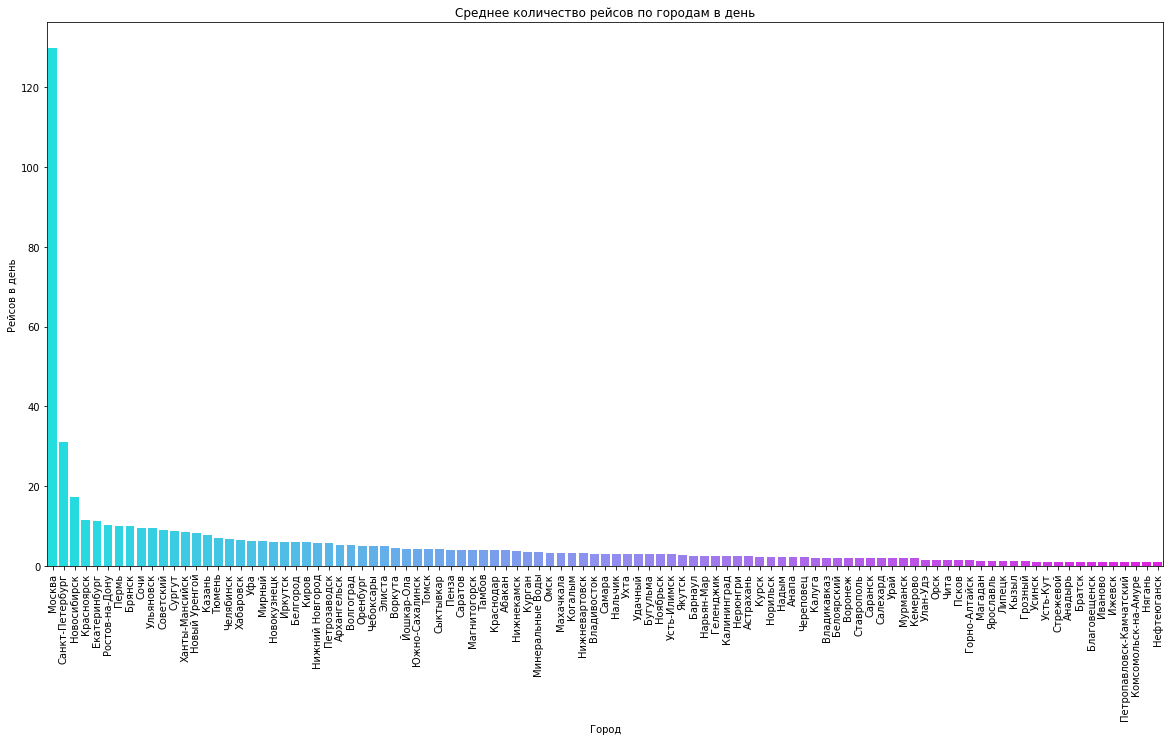

In [12]:
sns.barplot(x="city", y="average_flights", data=city_flights,
           order = city_flights.sort_values('average_flights', ascending=False)['city'], palette='cool')
plt.title('Среднее количество рейсов по городам в день')
plt.xlabel('Город')
plt.ylabel('Рейсов в день')
plt.xticks(rotation=90);

Наибольшее количество рейсов приходится на Москву и Санкт-Петербург, что достаточно логично, наименьшее - на Комсомольск-на-Амуре, Нягань и Нефтеюганск. Впрочем представлять на одном графике 101 направление не очень наглядно, поэтому покажем 10 самых крупных городов по количеству рейсов.

3. Топ-10 городов по количеству рейсов

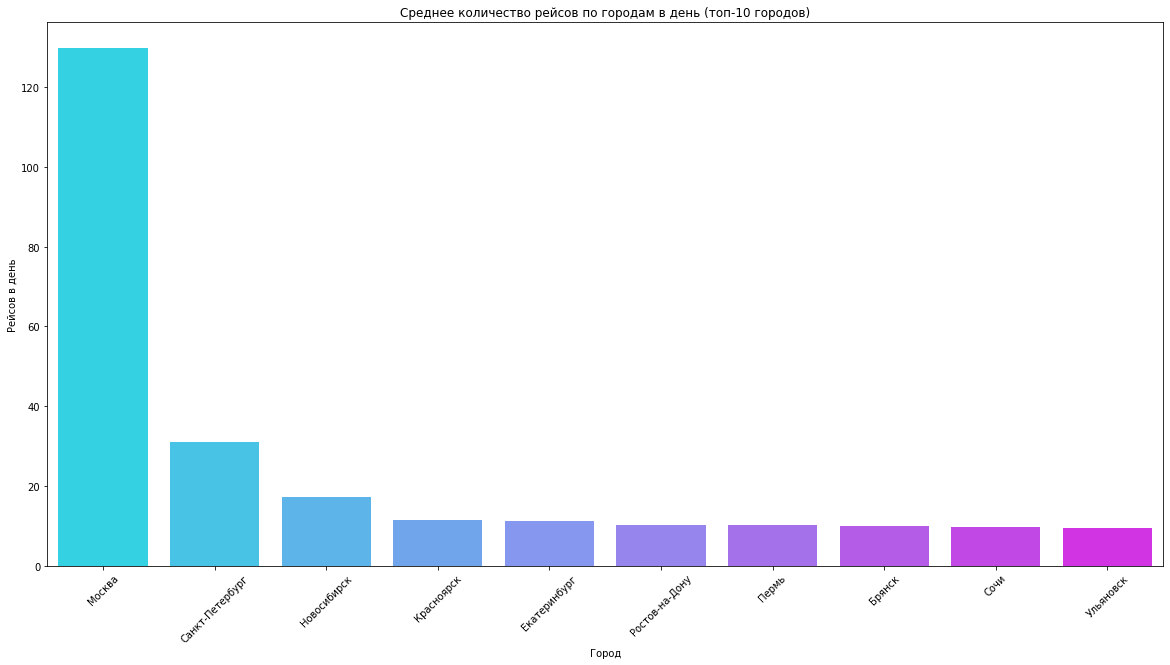

In [13]:
sns.barplot(x="city", y="average_flights", data=city_flights,
           order = city_flights.sort_values('average_flights', ascending=False)['city'].head(10), palette='cool')
plt.title('Среднее количество рейсов по городам в день (топ-10 городов)')
plt.xlabel('Город')
plt.ylabel('Рейсов в день')
plt.xticks(rotation=45);

В целом данные похожи на топ аэропортов по пассажиропотоку в России.

<details>
  <summary>Данные по пассажиропатоку</summary>
  
    
    https://ru.wikipedia.org/wiki/Список_наиболее_загруженных_аэропортов_России
  
</details>

Москва, в которой находятся 3 крупных аэропорта ожидаемо на первом месте (ко всему прочему логично что в сентябре люди как раз возвращаются из отпусков домой. Выделяются разве что аэропорты Брянска и Ульяновска которые, хотя и существуют, не входят в сотню самых загруженных аэропортов России. 

## Вывод

Данные загружены и проанализированны, построены графики количества рейсов по моделям самолетов, а также графики среднего количества в день по городам. Определены самые популярные города по количеству рейсов - Москва и Санкт-Петербург. Данные по распределению рейсов мо моделям самолетов говорят о том, что больше всего рейсов совершается на Cessna 208 и вероятнее всего являются некорректными. 

# 2. Проверка гипотезы

Загрузим данные последнего запроса.

In [14]:
festival_tickets=pd.read_csv('/datasets/query_last.csv')

In [15]:
festival_tickets

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


In [16]:
festival_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
week_number      10 non-null int64
ticket_amount    10 non-null int64
festival_week    3 non-null float64
festival_name    3 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 448.0+ bytes


Проверим гипотезу о том, что cредний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время.
Сформируем нулевую гипотезу. Так как как правило нулевая гипотеза должна включать в себя условие равенства, она будет звучать так - средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время. Соответственно альтернативная гипотеза - средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время.

Так как объем выборки крайне мал будем использовать F-критерий, который используется для малых и средних выборках (n<100). Однако даже к этим результатам следует отнестить с изрядкой долей скепсиса, так как у нас есть всего 3 значения в одной и 7 значений в другой выборке. Этого слишком мало чтобы можно было получить какой-либо адекватный результат.

Критический уровень статистической значимости зададим равным 5%

In [17]:
alpha = .05
results = st.ttest_ind(festival_tickets[festival_tickets['festival_name'].isna()]['ticket_amount'], 
                       festival_tickets[~festival_tickets['festival_name'].isna()]['ticket_amount'])
            
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.09688869045922928
Не получилось отвергнуть нулевую гипотезу


## Вывод

Итак, отвергнуть гипотезу о том, что спрос на билеты во время фестивалей не отличается от спроса в обычные дни не получилось. Если просмотреть данные по количеству билетов, корреляция между ними и фактам фестиваля действительно не очень заметна. Смущает только, что количество билетов за неделю 30 составляет 43568, что значительно меньше количества билетов в остальные недели (около 51000) Вероятнее всего это какая-то ошибка в данных (из-за которой, кстати, p-значение получилось достаточно малым, гораздо меньше чем следовало бы ожидать от столь равномерного распределения данных)

# Общий вывод.

Была изучена база данных и проанализирован спрос пассажиров на рейсы. Наиболее популярным направлением ожидаемо оказались Москва и Санкт-Петербург, наименее - Комсомольск-на-Амуре, Нягань и Нефтеюганск. 
Была проверена гипотеза о том, что спрос на билеты во время фестивалей не отличается от спроса в обычные дни. Отвергнуть эту гипотезу не получилось. Действительно, спрос вероятнее всего не изменяется от факта проведения фестиваля. Мы могли бы ожидать повышения спроса, однако этого не произошло (в одну из недель фестиваля спрос оказался даже значительно меньше, что заставляет подозревать ошибку)  